In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from graphino.GCN.GCN_model import GCN
from graphino.training import get_static_feats
from utilities.data_wrangling import load_cnn_data
from utilities.plotting import plot_centrality_from_adj
import warnings
warnings.filterwarnings("ignore")

# Eigenvector Centrality Heatmaps of the learned world connectivity structure
## $-$ This notebook corresponds to Fig. 2 in the paper

It will reload all pre-trained models corresponding to th Fig. 2 plots, and compute
the eigenvector centrality score of all nodes, to then produce a heatmap of them.
The used models have the strongest performance among the four ensemble members reported in our main results.

In [ ]:
def reload_and_plot_eigv_centrality(model_dir, lead_months, data_dir=None, device='cuda', ID='50ep'):
    out = f'out/{lead_months}lead/'
    try:
        model_dir = out + model_dir
        model_dict = torch.load(os.path.join(model_dir, ID + '_model.pkl'))
    except FileNotFoundError as e:
        print(e)
        return
    params, net_params = model_dict['metadata']['params'], model_dict['metadata']['net_params']
    load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node'], 
    }
    if data_dir is not None:
        load_data_kwargs['data_dir'] = data_dir
    cmip5, SODA, GODAS, cords = load_cnn_data(**load_data_kwargs,
                                                return_new_coordinates=True,
                                                return_mask=False, verbose=False)
    static_feats = get_static_feats(params, net_params, cords, SODA[0])
    lats, lons = GODAS[0].attrs["Lats"], GODAS[0].attrs["Lons"]

    model = GCN(net_params, static_feat=static_feats, verbose=False)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)

    adj = model.graph_learner().detach().cpu().numpy()
    if net_params['index_node']:  # do not plot the index node
        adj = adj[:-1, :-1]
    plot_centrality_from_adj(adj, lats, lons, coordinates=cords, save_to=None, set_title=False, verbose=False,
                                    min_weight=0, show=True, horizon=params['horizon'])


In [10]:
kwargs = {
    'device': 'cuda',
    'ID': '50ep', 
    'data_dir': './Data/'
}

# 1 lead

MASKING OUT 384 nodes


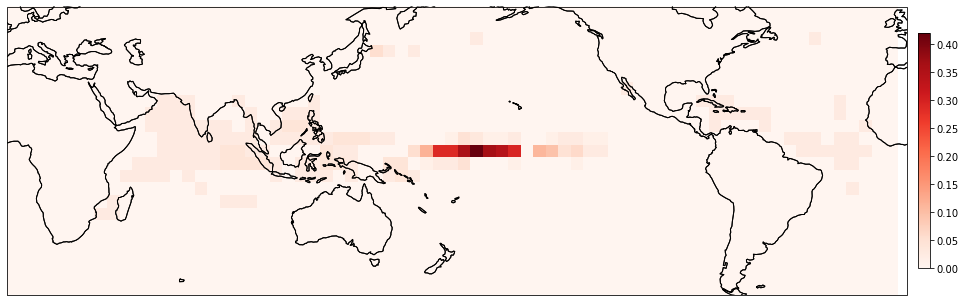

In [30]:
reload_and_plot_eigv_centrality('250x250', lead_months=1, **kwargs)

# 3 lead

MASKING OUT 384 nodes


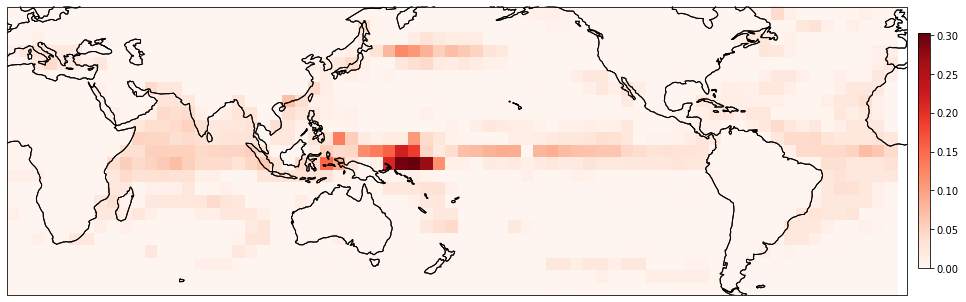

In [31]:
reload_and_plot_eigv_centrality('250x250', lead_months=3, **kwargs)

# 6 lead

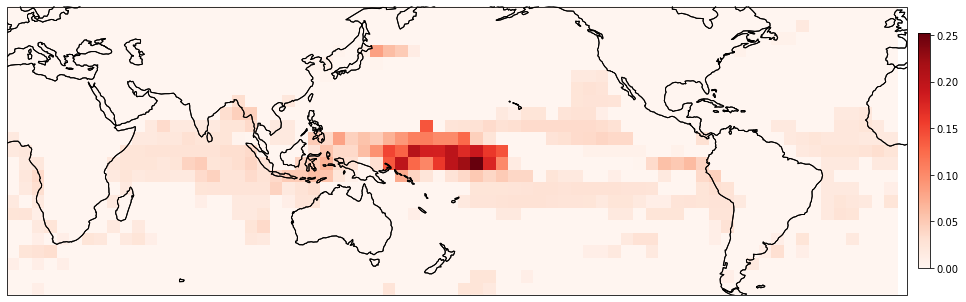

In [35]:
reload_and_plot_eigv_centrality('200x200x200_Mean+Sum', lead_months=6, **kwargs)


# 9 lead

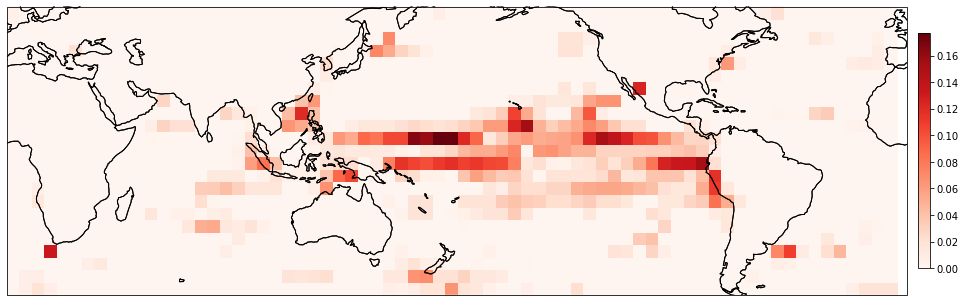

In [36]:
reload_and_plot_eigv_centrality('250x250', lead_months=9, **kwargs)


# 12 lead

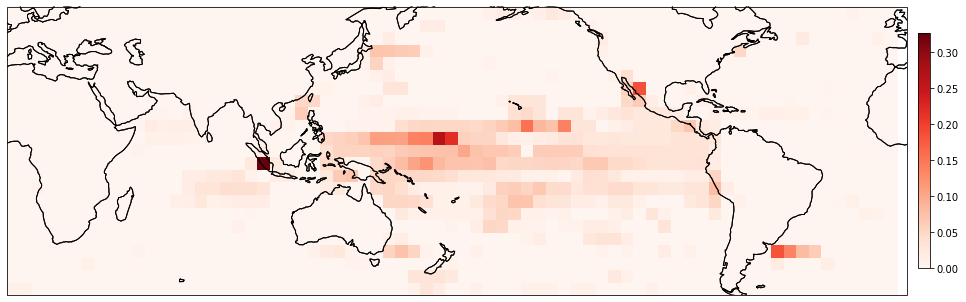

In [37]:
reload_and_plot_eigv_centrality('200x200x200_Mean+Sum', lead_months=12, **kwargs)


# 23 lead

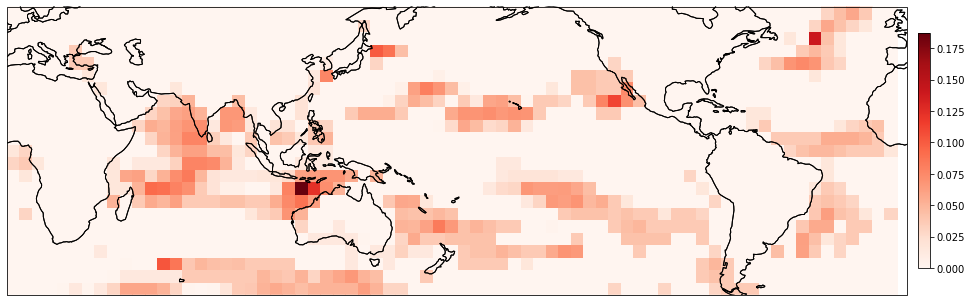

In [38]:
reload_and_plot_eigv_centrality('200x200x200_Mean+Sum', lead_months=23, **kwargs)